# Breast Histopathology Images
Las imágenes proporcionadas en https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/data tienen una dimensión de 50x50 y están a color (RGB).

In [12]:
import os
import zipfile
import random
import shutil
import glob
import numpy as np
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from PIL import Image

In [2]:
breast_imgs = glob.glob('breast-histopathology-images/IDC_regular_ps50_idx5/**/**.png', recursive = True)

In [3]:
for imgname in breast_imgs[:5]:
    print(imgname)    

breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png


In [14]:
non_cancer_imgs = []
cancer_imgs = []

for img in breast_imgs:
    if img[-5] == '0':
        non_cancer_imgs.append(img)
    elif img[-5] == '1':
        cancer_imgs.append(img)

non_cancer_num = len(non_cancer_imgs)
cancer_num = len(cancer_imgs) 
total_img_num = non_cancer_num + cancer_num

# Mostrar 
print('Número de imágenes sin cáncer: {}'.format(non_cancer_num))
print('Número de imágenes con cáncer: {}'.format(cancer_num))
print('Total de imágenes: {}'.format(total_img_num))



Número de imágenes sin cáncer: 198738
Número de imágenes con cáncer: 78786
Total de imágenes: 277524


In [15]:
carpeta_nocancer = 'Version2/no-cancer/'

for img in non_cancer_imgs:
    shutil.copy(img, carpeta_nocancer)


In [5]:
carpeta_cancer = 'Version2/cancer/'

for img in cancer_imgs:
    shutil.copy(img, carpeta_cancer)


In [34]:
imagenes_carpeta_cancer = glob.glob('Version2/cancer/**.png', recursive = True)
imagenes_carpeta_nocancer = glob.glob('Version2/no-cancer/**.png', recursive = True)

print('Imágenes de carpeta cancer: {}' .format(len(imagenes_carpeta_cancer)))
print('Imágenes de carpeta no-cancer: {}' .format(len(imagenes_carpeta_nocancer)))

Imágenes de carpeta cancer: 188786
Imágenes de carpeta no-cancer: 198738


In [22]:
random.seed(2)
cancer_sample = random.sample(non_cancer_imgs, min(len(cancer_imgs), 25000))
# Define los parámetros de ampliación de datos
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Carpeta que contiene las imágenes de cáncer
cancer_folder = 'Version2/cancer/'

# Obtén la lista de imágenes de cáncer
cancer_images = glob.glob(os.path.join(cancer_folder, '*.png'))

# Especifica la carpeta donde se guardarán las imágenes ampliadas
augmented_folder = 'Version2/cancer/'

# Crea la carpeta ampliada si no existe
if not os.path.exists(augmented_folder):
    os.makedirs(augmented_folder)

# Aplica transformaciones a cada imagen y guarda las imágenes ampliadas
for img_path in cancer_sample:
    img = mpimg.imread(img_path)
    img = np.expand_dims(img, axis=0)
    # Genera imágenes ampliadas
    augmented_images = datagen.flow(img, batch_size=1, save_to_dir=augmented_folder, save_prefix='aug', save_format='png')
    
    # Genera y guarda todas las imágenes ampliadas para cada imagen original
    for i in range(4): 
        augmented_image = augmented_images.next()[0]  # Extrae la imagen del lote
        augmented_image = image.array_to_img(augmented_image)  # Convierte a objeto de imagen
        augmented_image = augmented_image.resize((50, 50))  # Redimensiona a 50x50 píxeles
        augmented_image_path = os.path.join(augmented_folder, f'aug_{i}_{os.path.basename(img_path)}')
        augmented_image.save(augmented_image_path)

# Imprime el número de imágenes ampliadas generadas
imagenes_ampliadas = glob.glob(os.path.join(augmented_folder, '*.png'))
print('Número de imágenes ampliadas: {}'.format(len(imagenes_ampliadas)))

Número de imágenes ampliadas: 188786


In [41]:
imagenes_carpeta_cancer = glob.glob('Version2/cancer/**.png', recursive=True)
imagenes_carpeta_nocancer = glob.glob('Version2/no-cancer/**.png', recursive=True)

total_img_num = len(imagenes_carpeta_cancer) + len(imagenes_carpeta_nocancer)
print('Imágenes de carpeta cancer: {}'.format(len(imagenes_carpeta_cancer)))
print('Imágenes de carpeta no-cancer: {}'.format(len(imagenes_carpeta_nocancer)))
print('Total de imágenes : {}'.format(total_img_num))

Imágenes de carpeta cancer: 188786
Imágenes de carpeta no-cancer: 198738
Total de imágenes : 387524


In [42]:
carpeta_nocancer = 'Version2/no-cancer/'
carpeta_cancer = 'Version2/cancer/'
entrenamiento_cancer = 'Version2/entrenamiento/cancer/'
entrenamiento_nocancer = 'Version2/entrenamiento/nocancer/'
test_cancer = 'Version2/test/cancer/'
test_nocancer = 'Version2/test/nocancer/'

In [43]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [44]:
split_size = .8
random.seed(1)
split_data(carpeta_cancer, entrenamiento_cancer, test_cancer, split_size)
split_data(carpeta_nocancer, entrenamiento_nocancer, test_nocancer, split_size)

In [45]:
entrenamiento_cancer = 'Version2/entrenamiento/cancer/'
entrenamiento_nocancer = 'Version2/entrenamiento/nocancer/'
test_cancer = 'Version2/test/cancer/'
test_nocancer = 'Version2/test/nocancer/'

datos_entrenamiento_cancer = glob.glob('Version2/entrenamiento/cancer/**.png', recursive = True)
datos_entrenamiento_nocancer = glob.glob('Version2/entrenamiento/nocancer/**.png', recursive = True)
datos_test_cancer = glob.glob('Version2/test/cancer/**.png', recursive = True)
datos_test_nocancer = glob.glob('Version2/test/nocancer/**.png', recursive = True)


print('Imágenes de entrenamiento sin cancer: {}' .format(len(datos_entrenamiento_cancer)))
print('Imágenes de entrenamiento con cancer: {}' .format(len(datos_entrenamiento_nocancer)))
print('Imágenes de entrenamiento total: {}' .format(len(datos_entrenamiento_nocancer)+len(datos_entrenamiento_cancer)))
print('Imágenes de test sin cancer: {}' .format(len(datos_test_cancer)))
print('Imágenes de test con cancer: {}' .format(len(datos_test_nocancer)))
print('Imágenes de test total: {}' .format(len(datos_test_nocancer)+len(datos_test_cancer)))

Imágenes de entrenamiento sin cancer: 151028
Imágenes de entrenamiento con cancer: 158990
Imágenes de entrenamiento total: 310018
Imágenes de test sin cancer: 37758
Imágenes de test con cancer: 39748
Imágenes de test total: 77506


# RNC

In [46]:
TRAINING_DIR = "Version2/entrenamiento/"
 
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(50, 50))

VALIDATION_DIR = "Version2/test/"

validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(50, 50))

print(train_generator.n)
print(validation_generator.n)

Found 310018 images belonging to 2 classes.
Found 77506 images belonging to 2 classes.
310018
77506


## Modelo 1

In [52]:
checkpoint = ModelCheckpoint('Version2/Pesos/Modelo1/pesos_del_modelo_epoch_{epoch:02d}.h5', 
                             save_weights_only=True, 
                             save_best_only=False)

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Recall()])


In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 11, 11, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 64)         

In [65]:
history = model.fit(train_generator,
                              steps_per_epoch= 150,
                              epochs=70,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks=checkpoint)

Epoch 1/70
150/150 [==============================] - 117s 785ms/step - loss: 0.4470 - accuracy: 0.7882 - recall_1: 0.8310 - val_loss: 0.5418 - val_accuracy: 0.6558 - val_recall_1: 0.4912
Epoch 2/70
150/150 [==============================] - 115s 768ms/step - loss: 0.4400 - accuracy: 0.7933 - recall_1: 0.8459 - val_loss: 0.4088 - val_accuracy: 0.8115 - val_recall_1: 0.7836
Epoch 3/70
150/150 [==============================] - 114s 762ms/step - loss: 0.4305 - accuracy: 0.7989 - recall_1: 0.8432 - val_loss: 0.4197 - val_accuracy: 0.8017 - val_recall_1: 0.7739
Epoch 4/70
150/150 [==============================] - 113s 758ms/step - loss: 0.4127 - accuracy: 0.8108 - recall_1: 0.8526 - val_loss: 0.4019 - val_accuracy: 0.8140 - val_recall_1: 0.9259
Epoch 5/70
150/150 [==============================] - 110s 739ms/step - loss: 0.4044 - accuracy: 0.8110 - recall_1: 0.8644 - val_loss: 0.3782 - val_accuracy: 0.8291 - val_recall_1: 0.8434
Epoch 6/70
150/150 [==============================] - 109s 7

150/150 [==============================] - 90s 602ms/step - loss: 0.3344 - accuracy: 0.8530 - recall_1: 0.8883 - val_loss: 0.3228 - val_accuracy: 0.8572 - val_recall_1: 0.9006
Epoch 45/70
150/150 [==============================] - 90s 600ms/step - loss: 0.3341 - accuracy: 0.8536 - recall_1: 0.8917 - val_loss: 0.3160 - val_accuracy: 0.8618 - val_recall_1: 0.9324
Epoch 46/70
150/150 [==============================] - 89s 599ms/step - loss: 0.3235 - accuracy: 0.8585 - recall_1: 0.8975 - val_loss: 0.3207 - val_accuracy: 0.8594 - val_recall_1: 0.8619
Epoch 47/70
150/150 [==============================] - 89s 598ms/step - loss: 0.3315 - accuracy: 0.8537 - recall_1: 0.8923 - val_loss: 0.3138 - val_accuracy: 0.8623 - val_recall_1: 0.9323
Epoch 48/70
150/150 [==============================] - 89s 597ms/step - loss: 0.3275 - accuracy: 0.8566 - recall_1: 0.8947 - val_loss: 0.3075 - val_accuracy: 0.8663 - val_recall_1: 0.9144
Epoch 49/70
150/150 [==============================] - 89s 596ms/step - 

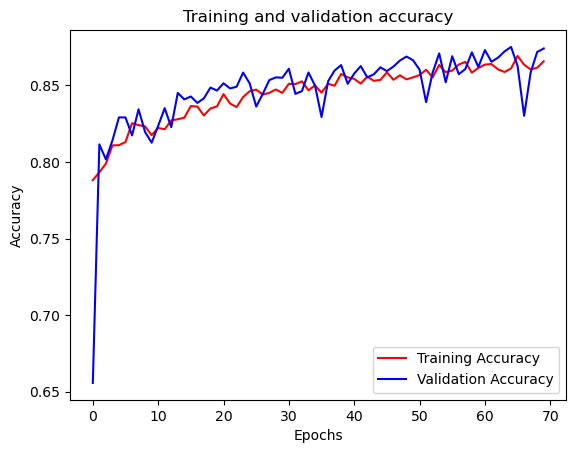

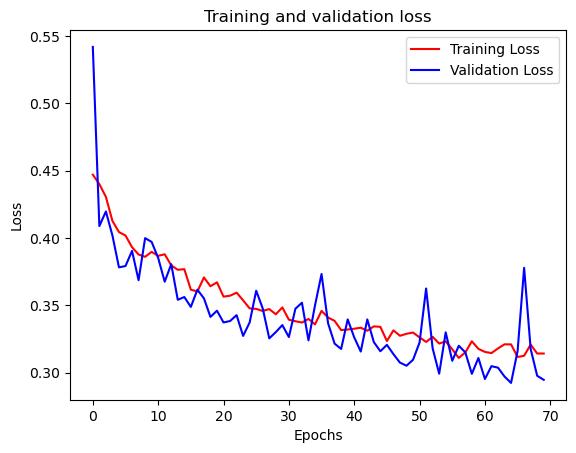

In [66]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()  
plt.show()

plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [58]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'recall_1', 'val_loss', 'val_accuracy', 'val_recall_1'])


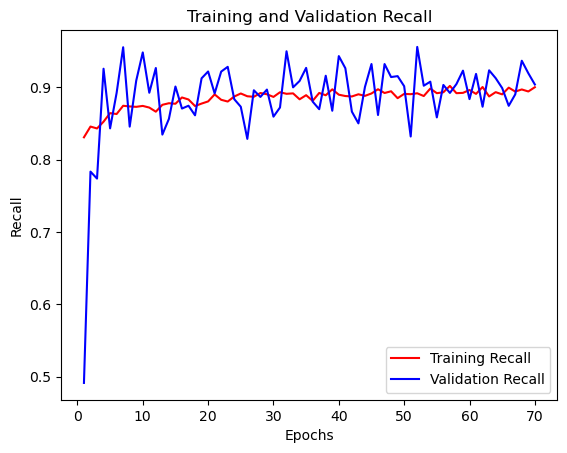

In [67]:
recall = history.history['recall_1']
val_recall = history.history['val_recall_1']

# Gráfico de Recall
plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [70]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [84]:
# Obtener las predicciones en el conjunto de validación
predictions = model.predict(validation_generator)


776/776 [==============================] - 68s 88ms/step


In [87]:
print("Clases del conjunto de validación:", validation_generator.class_indices)
# Aplicar un umbral para convertir las probabilidades en clases binarias (0 o 1)
threshold = 0.5 
predicted_labels = (predictions > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de validación
true_labels = validation_generator.classes

# Crear la matriz de confusión
confusion_mat = confusion_matrix(true_labels, predicted_labels)

print("Matriz de Confusión:")
print(confusion_mat)

# Imprimir el informe de clasificación
print("Informe de Clasificación:")
print(classification_report(true_labels, predicted_labels))

Clases del conjunto de validación: {'cancer': 0, 'nocancer': 1}
Matriz de Confusión:
[[17372 20386]
 [18305 21443]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.49      0.46      0.47     37758
           1       0.51      0.54      0.53     39748

    accuracy                           0.50     77506
   macro avg       0.50      0.50      0.50     77506
weighted avg       0.50      0.50      0.50     77506



In [88]:
TRAINING_DIR2 = "Version2/entrenamiento/"
 
train_datagen2 = ImageDataGenerator()

train_generator2 = train_datagen2.flow_from_directory(TRAINING_DIR2,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(50, 50))

VALIDATION_DIR2 = "Version2/test/"

validation_datagen2 = ImageDataGenerator()

validation_generator2 = validation_datagen2.flow_from_directory(VALIDATION_DIR2,
                                                              batch_size=64,
                                                              class_mode='binary',
                                                              target_size=(50, 50))

Found 310018 images belonging to 2 classes.
Found 77506 images belonging to 2 classes.


In [89]:
checkpoint2 = ModelCheckpoint('Version2/Pesos/Modelo2/pesos_del_modelo_epoch_{epoch:02d}.h5', 
                             save_weights_only=True, 
                             save_best_only=False)

In [90]:
history2 = model.fit(train_generator2,
                              steps_per_epoch= 150,
                              epochs=70,
                              verbose=1,
                              validation_data=validation_generator2,
                              callbacks=checkpoint2)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Recall()])

Epoch 1/70
150/150 [==============================] - 33s 222ms/step - loss: 38.7000 - accuracy: 0.7332 - recall_1: 0.7384 - val_loss: 2.1473 - val_accuracy: 0.7383 - val_recall_1: 0.7684
Epoch 2/70
150/150 [==============================] - 33s 218ms/step - loss: 0.8726 - accuracy: 0.7460 - recall_1: 0.7842 - val_loss: 0.4802 - val_accuracy: 0.7913 - val_recall_1: 0.9390
Epoch 3/70
150/150 [==============================] - 33s 223ms/step - loss: 0.5042 - accuracy: 0.7861 - recall_1: 0.8453 - val_loss: 0.4962 - val_accuracy: 0.8250 - val_recall_1: 0.9330
Epoch 4/70
150/150 [==============================] - 33s 223ms/step - loss: 0.5025 - accuracy: 0.7950 - recall_1: 0.8539 - val_loss: 0.4435 - val_accuracy: 0.8048 - val_recall_1: 0.9428
Epoch 5/70
150/150 [==============================] - 33s 224ms/step - loss: 0.4259 - accuracy: 0.8102 - recall_1: 0.8634 - val_loss: 0.3715 - val_accuracy: 0.8294 - val_recall_1: 0.9287
Epoch 6/70
150/150 [==============================] - 33s 221ms/

Epoch 45/70
150/150 [==============================] - 32s 217ms/step - loss: 0.3356 - accuracy: 0.8579 - recall_1: 0.8988 - val_loss: 0.3164 - val_accuracy: 0.8600 - val_recall_1: 0.9478
Epoch 46/70
150/150 [==============================] - 32s 217ms/step - loss: 0.3480 - accuracy: 0.8587 - recall_1: 0.9006 - val_loss: 0.3058 - val_accuracy: 0.8666 - val_recall_1: 0.9354
Epoch 47/70
150/150 [==============================] - 33s 219ms/step - loss: 0.3267 - accuracy: 0.8657 - recall_1: 0.9075 - val_loss: 0.3151 - val_accuracy: 0.8701 - val_recall_1: 0.9224
Epoch 48/70
150/150 [==============================] - 32s 216ms/step - loss: 0.3541 - accuracy: 0.8540 - recall_1: 0.8912 - val_loss: 0.3209 - val_accuracy: 0.8692 - val_recall_1: 0.9272
Epoch 49/70
150/150 [==============================] - 33s 220ms/step - loss: 0.3557 - accuracy: 0.8520 - recall_1: 0.9020 - val_loss: 0.3808 - val_accuracy: 0.8389 - val_recall_1: 0.8070
Epoch 50/70
150/150 [==============================] - 33s 2

NameError: name 'model2' is not defined

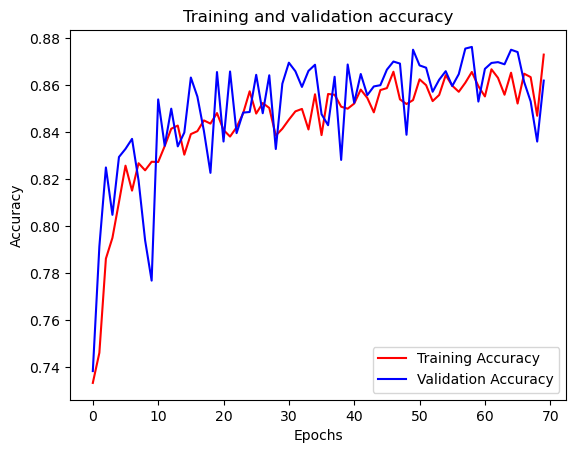

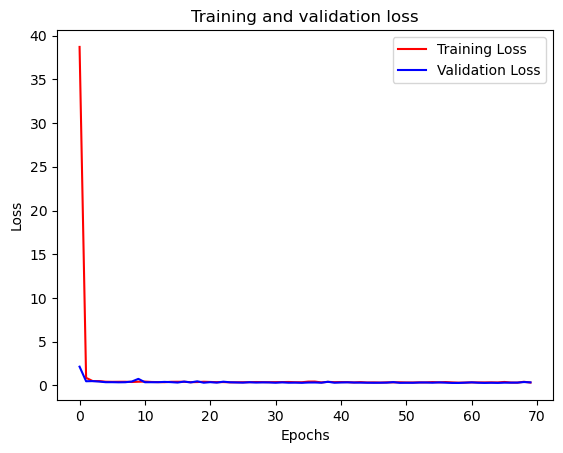

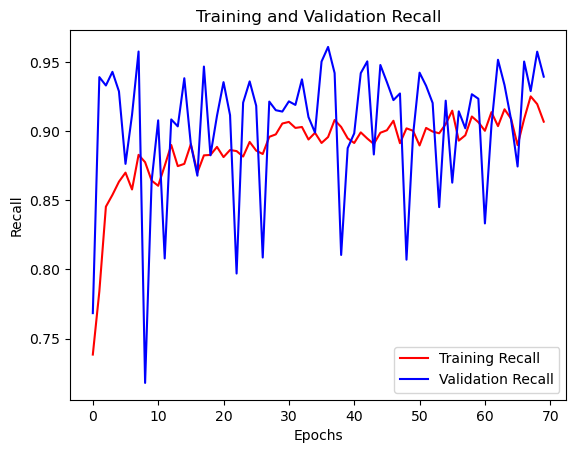

In [91]:
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()  
plt.show()

plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

recall = history2.history['recall_1']
val_recall = history2.history['val_recall_1']

# Gráfico de Recall
plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [92]:
# Obtener las predicciones en el conjunto de validación
predictions2 = model.predict(validation_generator2)

1212/1212 [==============================] - 26s 21ms/step


In [93]:
print("Clases del conjunto de validación:", validation_generator.class_indices)
# Aplicar un umbral para convertir las probabilidades en clases binarias (0 o 1)
threshold = 0.5 
predicted_labels = (predictions2 > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de validación
true_labels = validation_generator.classes

# Crear la matriz de confusión
confusion_mat = confusion_matrix(true_labels, predicted_labels)

print("Matriz de Confusión:")
print(confusion_mat)

# Imprimir el informe de clasificación
print("Informe de Clasificación:")
print(classification_report(true_labels, predicted_labels))

Clases del conjunto de validación: {'cancer': 0, 'nocancer': 1}
Matriz de Confusión:
[[15611 22147]
 [16270 23478]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.49      0.41      0.45     37758
           1       0.51      0.59      0.55     39748

    accuracy                           0.50     77506
   macro avg       0.50      0.50      0.50     77506
weighted avg       0.50      0.50      0.50     77506



# VGG16

In [51]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Recall

# Cargar el modelo preentrenado (por ejemplo, VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Agregar capas adicionales para adaptar el modelo a tu tarea específica
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Construir el nuevo modelo
model2 = Model(inputs=base_model.input, outputs=output)

# Congelar las capas preentrenadas (opcional)
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo con la métrica de Recall
model2.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Recall()])

# Definir ModelCheckpoint para guardar los pesos con el mejor recall
checkpoint3 = ModelCheckpoint('Version2/Pesos/Modelo2/best_weights.h5', 
                             save_weights_only=True, 
                             save_best_only=True,
                             monitor='val_recall',
                             mode='max', 
                             verbose=1)

# Entrenar el modelo con ajuste fino
history2 = model2.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=3,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])


 6332416/58889256 [==>...........................] - ETA: 4:05:29

ValueError: Incomplete or corrupted file detected. The auto file hash does not match the provided value of 6d6bbae143d832006294945121d1f1fc.